## Image Captioning Model in PyTorch
This notebook provides an implementation of an image captioning model using PyTorch.

### Import Necessary Libraries

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
from glob import glob

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### Data Preparation
Load and preprocess your dataset.

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
image_data_location = "/content/drive/MyDrive/DL3/Images"
caption_data_location = "/content/drive/MyDrive/DL3/captions.txt"

In [ ]:
df = pd.read_csv(caption_data_location)

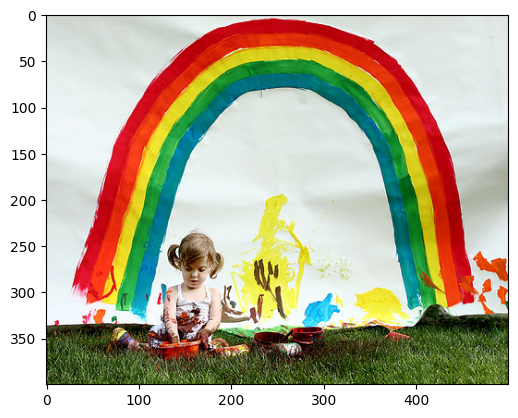

Caption - A little girl is sitting in front of a large painted rainbow .
Caption - A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
Caption - There is a girl with pigtails sitting in front of a rainbow painting .
Caption - Young girl with pigtails painting outside in the grass .
Caption - A man lays on a bench while his dog sits by him .


In [ ]:
data_idx = 11
image_path = image_data_location + "/" + df.iloc[data_idx,0]
# print( df.iloc[data_idx,:])
img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

for i in range(data_idx, data_idx+5):
    print(f"Caption - {df.iloc[i,1]}")

In [ ]:
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

In [ ]:
spacy_eng = spacy.load('en_core_web_sm')
text = "This is a good place to find a city"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

['this', 'is', 'a', 'good', 'place', 'to', 'find', 'a', 'city']

In [ ]:


class Vocabulary:
    def __init__(self,freq_threshold):
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]

    def build_vocab(self,sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self,text):
        tokenized_text = self.tokenize(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]

In [ ]:
v = Vocabulary(freq_threshold=1)
v.build_vocab(["This is a new city"])
print(v.stoi)
print(v.numericalize("This is a new city"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'new': 7, 'city': 8}
[4, 5, 6, 7, 8]


In [ ]:
df = pd.read_csv(caption_data_location)
print(df["image"][0][::-1])

gpj.e0bc80b396_1028620001


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)

        # Filter out entries where the image file does not exist
        self.df = self.df[self.df['image'].apply(lambda img: os.path.exists(os.path.join(root_dir, img)))]

        self.transform = transform
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]

        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        caption_vec = [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]

        return img, torch.tensor(caption_vec)


In [ ]:
#defing the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [ ]:
def show_image(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
# testing the dataset
dataset = CustomDataset(
        root_dir = image_data_location,
        captions_file = caption_data_location,
        transform = transforms
)

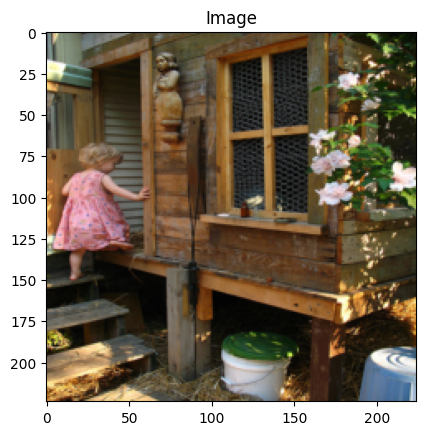

Token : tensor([  1,   4,  28,   8,   4, 195, 151,  17,  32,  67,   4, 353,  11, 711,
          8,  24,   3, 496,   5,   2])
Sentence: 
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [ ]:
img, caps = dataset[0]
# print(caps)
show_image(img,"Image")
print("Token :",caps)
print("Sentence: ")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [ ]:
class CapsCollate:
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
#         print(f"shape - {(imgs)}")
#         print("----"*22)
        imgs = torch.cat(imgs,dim=0)
#         print(f"shape - {imgs}")
#         print("------")
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [ ]:
#writing the dataloader
#setting the constants
BATCH_SIZE = 4
NUM_WORKER = 1

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

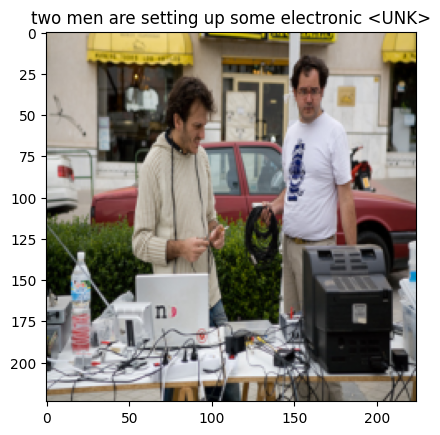

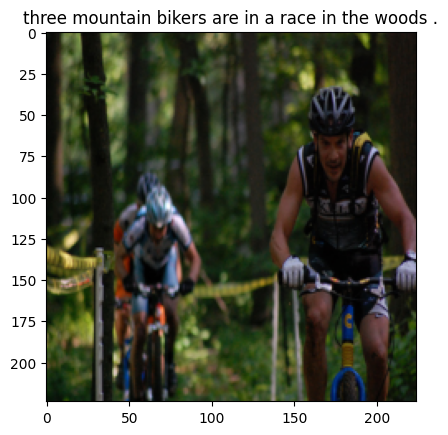

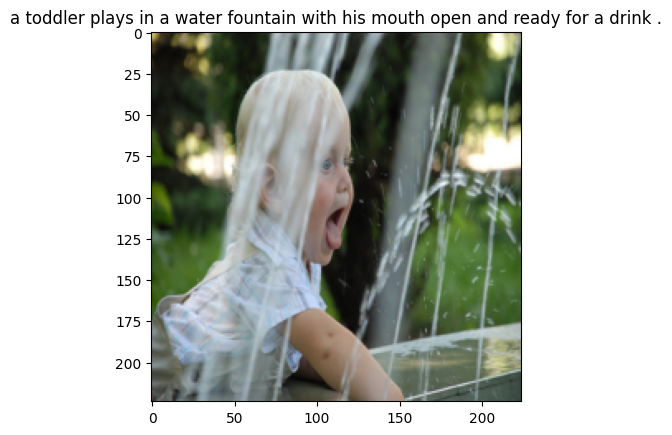

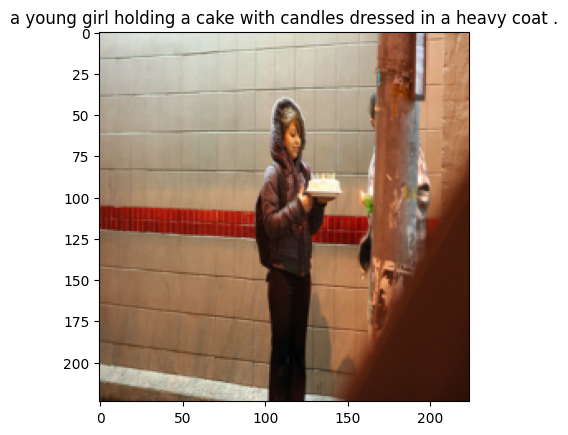

In [ ]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
#     print(f"captions - {captions[i]}")
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)
    show_image(img,caption_label)
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self,embed_size):
        super(EncoderCNN,self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features,embed_size)

    def forward(self,images):
        features = self.resnet(images)
#         print(f"resenet features shape - {features.shape}")
        features = features.view(features.size(0),-1)
#         print(f"resenet features viewed shape - {features.shape}")
        features = self.embed(features)
#         print(f"resenet features embed shape - {features.shape}")
        return features

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(DecoderRNN,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True)
        self.fcn = nn.Linear(hidden_size,vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self,features, captions):
        # vectorize the caption
#         print(f"captions - {captions[:,:-1]}")
#         print(f"caption shape - {captions[:,:-1].shape}")
        embeds = self.embedding(captions[:,:-1])
#         print(f"shape of embeds - {embeds.shape}")
        # concat the features and captions
#         print(f"features shape - {features.shape}")
#         print(f"features unsqueeze at index 1 shape - {features.unsqueeze(1).shape}")
        x = torch.cat((features.unsqueeze(1),embeds),dim=1)
#         print(f"shape of x - {x.shape}")
        x,_ = self.lstm(x)
#         print(f"shape of x after lstm - {x.shape}")
        x = self.fcn(x)
#         print(f"shape of x after fcn - {x.shape}")
        return x

    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions

        batch_size = inputs.size(0)

        captions = []
        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.fcn(output)
            output = output.view(batch_size,-1)


            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)

            #save the generated word
            captions.append(predicted_word_idx.item())

            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            #send generated word as the next caption
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))

        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions]

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(EncoderDecoder,self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
embed_size = 400
hidden_size = 512
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 0.0001
num_epochs = 2

In [ ]:
# initialize model, loss etc
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1 loss: 4.06042
features shape - torch.Size([1, 400])
<SOS> a man is running on a field . <EOS>


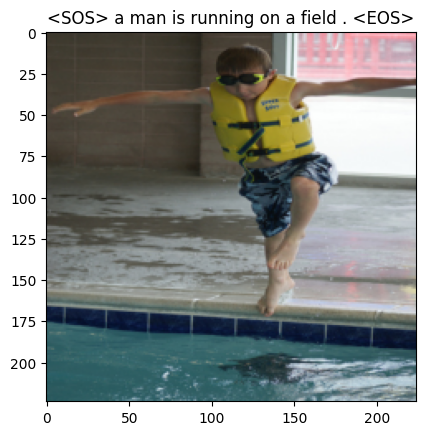

Epoch: 1 loss: 3.97474
features shape - torch.Size([1, 400])
<SOS> a man in a red shirt is standing on a <UNK> . <EOS>


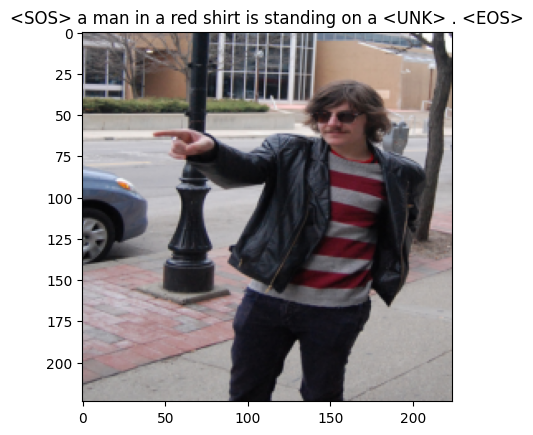

In [ ]:
num_epochs = 20
print_every = 2000

for epoch in range(1,num_epochs+1):
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)
        if image is None:
            # Handle the case where the image is not found
            continue

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs = model(image, captions)

        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))


        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))


            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                print(f"features shape - {features.shape}")
                caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=dataset.vocab)
                caption = ' '.join(caps)
                print(caption)
                show_image(img[0],title=caption)

            model.train()

In [ ]:
import torch

# Assuming your model is named 'model'
# You may replace 'your_model_name.pth' with the desired file name
torch.save(model.state_dict(), 'image_caption.pth')
